# Case Study #1 : Investigation Evidence
Do the image enhancement to get the good and usable images. Explain why and how?

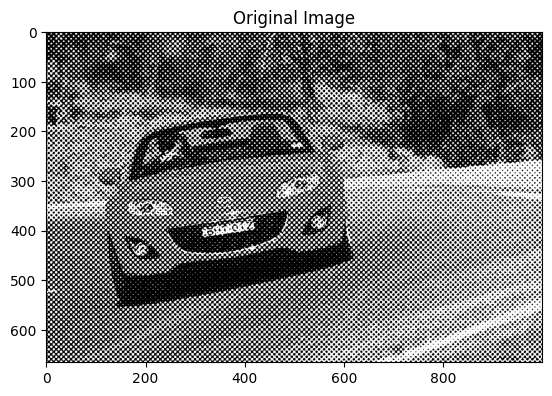

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load image in grayscale
img = cv2.imread('case1_1.png', 0)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.show()

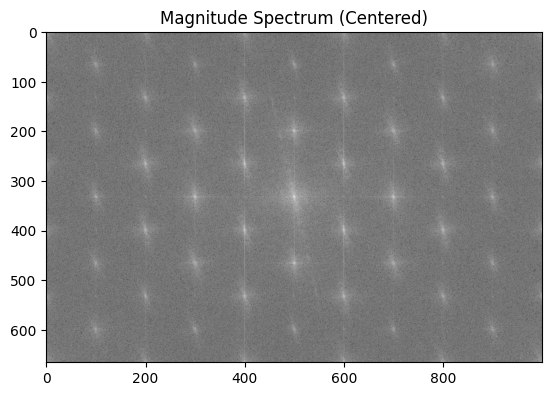

In [2]:
# Get image size
M, N = img.shape

# Compute DFT using FFT
f = np.fft.fft2(img)

# Shift zero frequency to center
fshift = np.fft.fftshift(f)

# Calculate magnitude spectrum (for visualization)
magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)

plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum (Centered)')
plt.show()

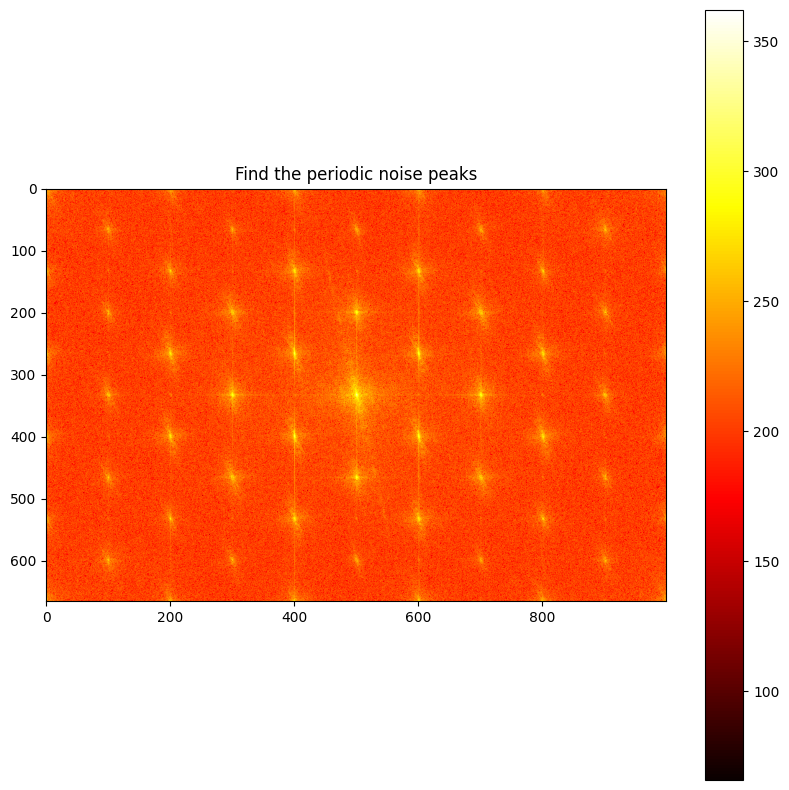

In [3]:
# Display with better contrast to find peaks
plt.figure(figsize=(10, 10))
plt.imshow(magnitude_spectrum, cmap='hot')
plt.colorbar()
plt.title('Find the periodic noise peaks')
plt.show()

In [4]:
def create_notch_reject_filter(shape, center, radius, notch_centers):
    """
    Create a notch reject filter
    
    shape: (M, N) size of filter
    center: (u_center, v_center) center of frequency domain
    radius: D0 - radius of each notch
    notch_centers: list of (u, v) coordinates of noise peaks
    """
    M, N = shape
    H = np.ones((M, N))
    
    for (u_k, v_k) in notch_centers:
        # Distance from positive peak
        D_k = np.zeros((M, N))
        # Distance from negative peak (symmetric)
        D_minus_k = np.zeros((M, N))
        
        for u in range(M):
            for v in range(N):
                D_k[u, v] = np.sqrt((u - u_k)**2 + (v - v_k)**2)
                D_minus_k[u, v] = np.sqrt((u - (M - u_k))**2 + (v - (N - v_k))**2)
        
        # Butterworth notch reject filter (order n=2)
        H_k = 1 / (1 + (radius / (D_k + 1e-5))**(2*2))
        H_minus_k = 1 / (1 + (radius / (D_minus_k + 1e-5))**(2*2))
        
        H = H * H_k * H_minus_k
    
    return H

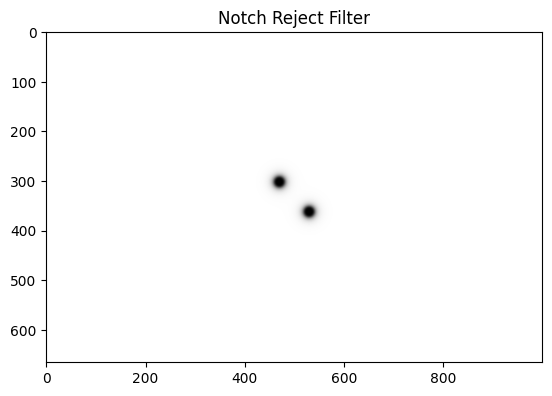

In [5]:
# Example: Identify peaks manually from the spectrum
# You need to find the actual coordinates from Step 3
# These are example coordinates - adjust based on your image!
notch_centers = [
    (M//2 + 30, N//2 + 30),   # Adjust these values
    (M//2 - 30, N//2 - 30),   # based on where you see peaks
]

# Create notch filter with radius D0
D0 = 10  # Adjust this radius
H_notch = create_notch_reject_filter(img.shape, (M//2, N//2), D0, notch_centers)

# Visualize the filter
plt.imshow(H_notch, cmap='gray')
plt.title('Notch Reject Filter')
plt.show()

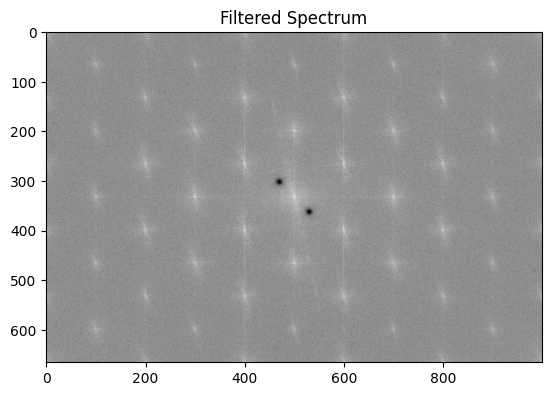

In [6]:
# Apply filter: G(u,v) = H(u,v) × F(u,v)
G = H_notch * fshift

# Visualize filtered spectrum
filtered_spectrum = 20 * np.log(np.abs(G) + 1)
plt.imshow(filtered_spectrum, cmap='gray')
plt.title('Filtered Spectrum')
plt.show()

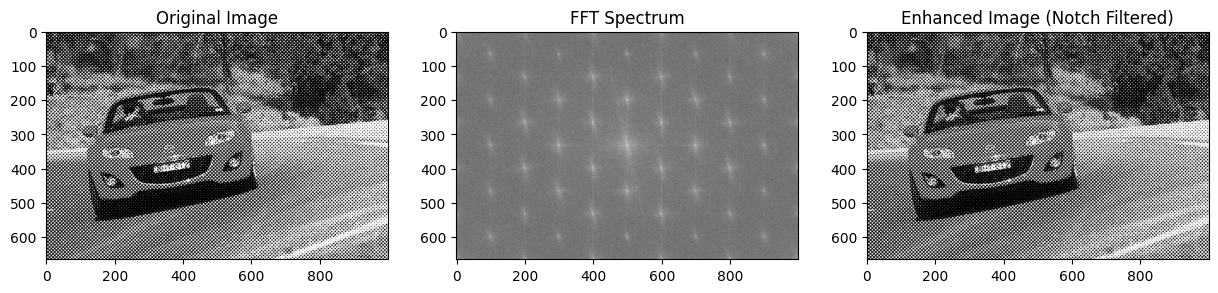

In [8]:
# Shift back
g_ishift = np.fft.ifftshift(G)

# Inverse FFT
img_back = np.fft.ifft2(g_ishift)
img_back = np.real(img_back)

# Clip values to valid range
img_back = np.clip(img_back, 0, 255).astype(np.uint8)

# Display result
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(img, cmap='gray')
plt.title('Original Image')

plt.subplot(132)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('FFT Spectrum')

plt.subplot(133)
plt.imshow(img_back, cmap='gray')
plt.title('Enhanced Image (Notch Filtered)')
plt.show()

In [ ]:
# Adjust parameters:
# 1. D0 (notch radius) - larger removes more but may blur
# 2. Add more notch_centers if you see more peaks
# 3. Try Gaussian notch filter instead of Butterworth

# Gaussian Notch Filter alternative:
def gaussian_notch(D_k, D0):
    return 1 - np.exp(-(D_k**2) / (2 * D0**2))